In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 
os.chdir("/content/drive/MyDrive/AI/dataset/pneumonia/chest_xray")

In [ ]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

print(tf.__version__)

warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.8.0


In [ ]:
a=list(paths.list_images("train"))

In [ ]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("train")))

random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]


        if label == "NORMAL":
            label = 0
        elif label == "PNEUMONIA":
            label = 1
        labels.append(label)
        
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/5216 [00:00<?, ?it/s]

In [ ]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
print(len(data))
print(len(labels))

5216
5216


In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [ ]:
trainX[0]


array([[[0.        , 0.        , 0.        ],
        [0.16862745, 0.16862745, 0.16862745],
        [0.42745098, 0.42745098, 0.42745098],
        ...,
        [0.42352941, 0.42352941, 0.42352941],
        [0.32156863, 0.32156863, 0.32156863],
        [0.10980392, 0.10980392, 0.10980392]],

       [[0.        , 0.        , 0.        ],
        [0.20392157, 0.20392157, 0.20392157],
        [0.43529412, 0.43529412, 0.43529412],
        ...,
        [0.45490196, 0.45490196, 0.45490196],
        [0.29019608, 0.29019608, 0.29019608],
        [0.05490196, 0.05490196, 0.05490196]],

       [[0.        , 0.        , 0.        ],
        [0.17647059, 0.17647059, 0.17647059],
        [0.43921569, 0.43921569, 0.43921569],
        ...,
        [0.51764706, 0.51764706, 0.51764706],
        [0.3254902 , 0.3254902 , 0.3254902 ],
        [0.04313725, 0.04313725, 0.04313725]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [ ]:
train_images = trainX.reshape(len(trainX),28,28,3)
test_images = testX.reshape(len(testX),28,28,3)

In [ ]:
#create model
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,3)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(2, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
 !pip install keras-tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [ ]:
from tensorflow import keras
import keras_tuner

In [ ]:

from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=10,directory='output',project_name="pneumonia3")

In [ ]:
tuner_search.search(train_images,labels,epochs=5,validation_split=0.1)

INFO:tensorflow:Oracle triggered exit


In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 80)        2240      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        23072     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 96)                1769568   
                                                                 
 dense_1 (Dense)             (None, 2)                 194       
                                                                 
Total params: 1,795,074
Trainable params: 1,795,074
Non-trainable params: 0
_________________________________________________________________


In [ ]:
r=model.fit(train_images, trainY, epochs=10, validation_split=0.1)

Epoch 1/10
110/110 [==============================] - 2s 14ms/step - loss: 0.3884 - accuracy: 0.8318 - val_loss: 0.2099 - val_accuracy: 0.9184
Epoch 2/10
110/110 [==============================] - 1s 12ms/step - loss: 0.1653 - accuracy: 0.9321 - val_loss: 0.1308 - val_accuracy: 0.9413
Epoch 3/10
110/110 [==============================] - 1s 12ms/step - loss: 0.1196 - accuracy: 0.9554 - val_loss: 0.1059 - val_accuracy: 0.9592
Epoch 4/10
110/110 [==============================] - 1s 12ms/step - loss: 0.1227 - accuracy: 0.9554 - val_loss: 0.1389 - val_accuracy: 0.9464
Epoch 5/10
110/110 [==============================] - 1s 12ms/step - loss: 0.0992 - accuracy: 0.9611 - val_loss: 0.1442 - val_accuracy: 0.9490
Epoch 6/10
110/110 [==============================] - 1s 12ms/step - loss: 0.1110 - accuracy: 0.9568 - val_loss: 0.1280 - val_accuracy: 0.9643
Epoch 7/10
110/110 [==============================] - 2s 14ms/step - loss: 0.0955 - accuracy: 0.9616 - val_loss: 0.0988 - val_accuracy: 0.9617

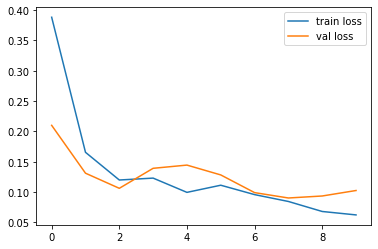

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Trainloss and validation loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

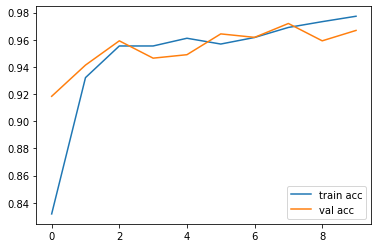

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')